## Preprocessing 

In [ ]:
import mne
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt

# EEG channels used
eeg_channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

def butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 


def extract_segments(raw_data, start_time, end_time, fs, segment_duration):
    """Extracts overlapping 3-second EEG segments."""
    segments = []
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)
    
    for seg_start in range(start_sample, end_sample, segment_duration * fs):  
        seg_end = seg_start + (segment_duration * fs)
        if seg_end <= raw_data.shape[1]: 
            segments.append(raw_data[:, seg_start:seg_end])  
    return segments

def process_edf(edf_path, annotation_path, participant_name, slider_values, fs=256, segment_duration=3):
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    raw.pick_channels(eeg_channels) 
    data = raw.get_data()

    data = butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=fs)

    data *= 1e6  

    annotations = pd.read_csv(annotation_path)
    segments = []
    labels = []

    for (start_label, end_label, slider_col, segment_label) in [
        ("T1 Learning Start", "T1 Learning End", "Slider_39", "T1"),
        ("T2 Learning Start", "T2 Learning End", "Slider_44", "T2"),
        ("T3 Learning Start", "T3 Learning End", "Slider_45", "T3"),
    ]:
        try:
            start_time = annotations.loc[annotations["Name"] == start_label, "latency"].values[0]
            end_time = annotations.loc[annotations["Name"] == end_label, "latency"].values[0]
            label_value = slider_values.loc[slider_values["Name"] == participant_name, slider_col].values[0]

            segment_data_list = extract_segments(data, start_time, end_time, fs, segment_duration)

            for segment_data in segment_data_list:
                segment_flattened = segment_data.flatten()  
                segments.append(segment_flattened)
                labels.append(label_value)

        except IndexError:
            print(f"Missing annotation for {participant_name}, {start_label} - {end_label}")

    return pd.DataFrame(segments), pd.Series(labels)

def main(edf_folder, annotation_folder, output_file):
    slider_values = pd.read_excel("../slider_values.xlsx")
    all_data = pd.DataFrame()

    for participant in slider_values['Name']:
        edf_path = os.path.join(edf_folder, f"{participant}.edf")
        annotation_path = os.path.join(annotation_folder, f"{participant}.csv")

        if not os.path.exists(edf_path) or not os.path.exists(annotation_path):
            print(f"Missing file for {participant}")
            continue

        segments_df, labels_series = process_edf(edf_path, annotation_path, participant, slider_values)
        segments_df['Label'] = labels_series.values
        segments_df['Participant'] = participant

        all_data = pd.concat([all_data, segments_df], ignore_index=True)

    all_data.to_csv(output_file, index=False)
    print(f"Saved processed data to {output_file}")

main("../EDF_Files", "../excel annotations/new", "DataAugmented.csv")


Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Prem_Ranjan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4557999  =      0.000 ...  2278.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Nido.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ...  3938.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Anshul.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4779999  =      0.000 ...  2389.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Prakathishwaran.edf...
EDF file detected
Setting channel info struct

In [ ]:
import pandas as pd

df = pd.read_csv("DataAugmented.csv")
print(df.iloc[:, -1]) 


0       Prem_Ranjan
1       Prem_Ranjan
2       Prem_Ranjan
3       Prem_Ranjan
4       Prem_Ranjan
           ...     
3039     Sai_Pranav
3040     Sai_Pranav
3041     Sai_Pranav
3042     Sai_Pranav
3043     Sai_Pranav
Name: Participant, Length: 3044, dtype: object


In [ ]:
import pandas as pd

df = pd.read_csv("DataAugmented.csv")

label_counts = df.iloc[:, -2].value_counts()
print(label_counts)


Label
Confusion      1698
Anxiety         792
Frustration     554
Name: count, dtype: int64


In [ ]:
import pandas as pd

df = pd.read_csv("DataAugmented.csv")

df.insert(0, "Name", df.pop("Participant")) 
df = df.sample(frac=1, random_state=42).reset_index(drop=True) 
df.to_csv("Shuffled_DataAugmented.csv", index=False)

print("✅ Shuffled dataset saved as Shuffled_DataAugmentated.csv")


✅ Shuffled dataset saved as Shuffled_DataAugmentated.csv


## Topo graphs

Effective window size : 1.024 (s)


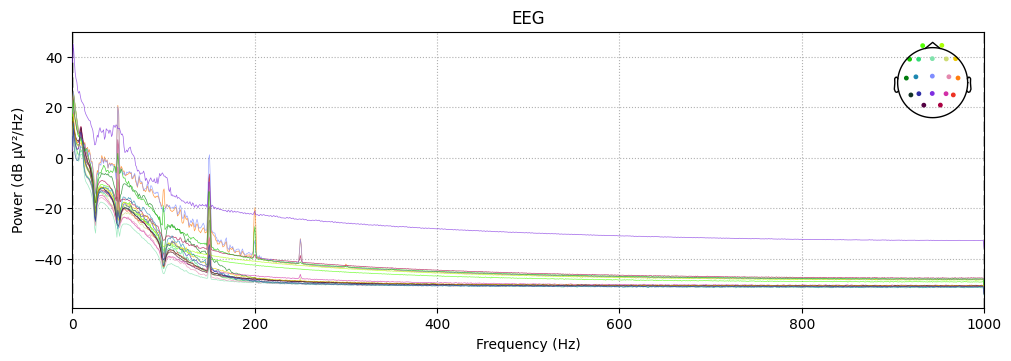

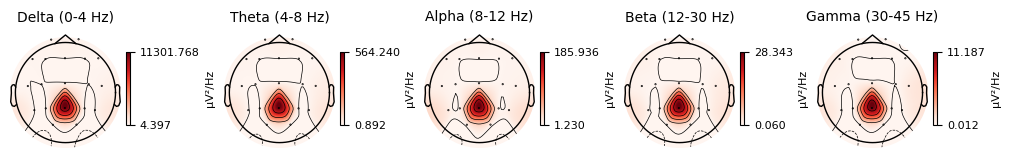

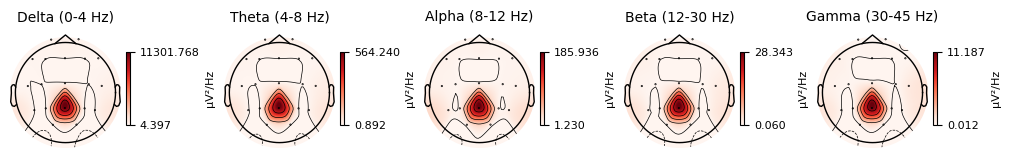

In [ ]:
raw_h = mne.io.read_raw_edf("../FYP/EDF_Files/Anshul.edf",preload=True)
eeg_channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']
raw=raw_h.pick_channels(eeg_channels)
raw.info
raw.set_montage('standard_1020')
raw.compute_psd().plot_topomap()

## Feature Extraction

In [5]:
%pip install mne-features antropy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [31]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import pywt
import antropy as ant
from mne_features.univariate import compute_hjorth_mobility, compute_hjorth_complexity

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 50),
}

def bandpower(data, sf, band):
    low, high = band
    freqs, psd = welch(data, sf, nperseg=sf*2)
    band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], dx=np.diff(freqs).mean())
    return band_power / np.trapz(psd, dx=np.diff(freqs).mean())  

def wavelet_energy(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet, level=4)
    energy = [np.sum(np.abs(c)**2) for c in coeffs]
    return energy


def extract_features(segment, fs=256):
    features = {}
    for ch in range(segment.shape[0]): 
        data = np.array(segment[ch], dtype=np.float64)

        # Hjorth Parameters
        features[f'Ch{ch}_Hjorth_Mobility'] = compute_hjorth_mobility(data)
        features[f'Ch{ch}_Hjorth_Complexity'] = compute_hjorth_complexity(data)

        # Statistical Features
        # features[f'Ch{ch}_Mean'] = np.mean(data)
        # features[f'Ch{ch}_Std'] = np.std(data)
        # features[f'Ch{ch}_Kurtosis'] = kurtosis(data)
        # features[f'Ch{ch}_Skewness'] = skew(data)

        # First & Second Differences
        # first_diff = np.diff(data)
        # second_diff = np.diff(first_diff)
        # features[f'Ch{ch}_First_Diff_Mean'] = np.mean(first_diff)
        # features[f'Ch{ch}_Second_Diff_Mean'] = np.mean(second_diff)

        # PSD using Welch’s method
        # freqs, psd = welch(data, fs, nperseg=fs*2)
        # max_power_idx = np.argmax(psd)
        # features[f'Ch{ch}_Max_Power'] = psd[max_power_idx]
        # features[f'Ch{ch}_Max_Power_Freq'] = freqs[max_power_idx]

        # Relative Band Power (RBP)
        # for band, freq_range in bands.items():
        #     features[f'Ch{ch}_RBP_{band}'] = bandpower(data, fs, freq_range)

        # Fractal Dimension
        # features[f'Ch{ch}_Higuchi_FD'] = ant.higuchi_fd(data)
        # features[f'Ch{ch}_Petrosian_FD'] = ant.petrosian_fd(data)

        # Wavelet Energy
        # wavelet_feats = wavelet_energy(data)
        # for i, val in enumerate(wavelet_feats):
        #     features[f'Ch{ch}_Wavelet_Energy_{i}'] = val

    return features

def process_segments(input_file, output_file, n_channels=19):
    df = pd.read_csv(input_file)
    eeg_data = df.iloc[:, 1:-1]  
    features_list = []

    for i in range(len(df)):
        sample = eeg_data.iloc[i].values
        n_samples = len(sample) // n_channels

        # Reshape
        segment = sample.reshape(n_channels, n_samples)
        features = extract_features(segment)

        
        features['Name'] = df.iloc[i, 0]
        features['Label'] = df.iloc[i, -1]
        features_list.append(features)

    feature_df = pd.DataFrame(features_list)
    feature_df.to_csv(output_file, index=False)
    print(f" Feature extraction completed. Saved to {output_file}")


process_segments("Shuffled_DataAugmented.csv", "ExtractedFeatures.csv")


 Feature extraction completed. Saved to ExtractedFeatures.csv


In [32]:
import pandas as pd

df = pd.read_csv("ExtractedFeatures.csv")

df.insert(0, "Name", df.pop("Name"))



df.to_csv("ExtractedFeatures.csv", index=False)



In [33]:
import pandas as pd
import numpy as np

file_path = "ExtractedFeatures.csv" 
df = pd.read_csv(file_path)

print(" Dataset Information:")
print(df.info())

numeric_df = df.select_dtypes(include=[np.number])

print("\n Checking for Missing Values:")
missing_values = numeric_df.isnull().sum().sum()
if missing_values > 0:
    print(f" Warning: {missing_values} missing values found!")
    print(numeric_df.isnull().sum())
else:
    print(" No missing values found.")

print("\n Checking for NaN and Infinite Values:")
if np.any(np.isnan(numeric_df.values)) or np.any(np.isinf(numeric_df.values)):
    print(" Warning: NaN or infinite values detected in the dataset!")
else:
    print(" No NaN or infinite values found.")

print("\n Feature Statistics:")
print(numeric_df.describe())

expected_features = [
    "Hjorth_Mobility", "Hjorth_Complexity", "Mean", "Std", "Kurtosis", "Skewness",
    "First_Diff_Mean", "Second_Diff_Mean", "Max_Power", "Max_Power_Freq", 
    "Higuchi_FD", "Petrosian_FD", "Hurst_Exponent"
]
missing_features = [feature for feature in expected_features if not any(feature in col for col in numeric_df.columns)]

print("\n Checking for Missing Features:")
if missing_features:
    print(f"Warning: The following features are missing: {missing_features}")
else:
    print("All expected features are present.")

print("\n Checking Label Distribution:")
if "Label" in df.columns:
    print(df["Label"].value_counts())
else:
    print(" Warning: 'Label' column is missing!")

print("\nFeature verification completed.")


 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    3044 non-null   object 
 1   Ch0_Hjorth_Mobility     3044 non-null   float64
 2   Ch0_Hjorth_Complexity   3044 non-null   float64
 3   Ch1_Hjorth_Mobility     3044 non-null   float64
 4   Ch1_Hjorth_Complexity   3044 non-null   float64
 5   Ch2_Hjorth_Mobility     3044 non-null   float64
 6   Ch2_Hjorth_Complexity   3044 non-null   float64
 7   Ch3_Hjorth_Mobility     3044 non-null   float64
 8   Ch3_Hjorth_Complexity   3044 non-null   float64
 9   Ch4_Hjorth_Mobility     3044 non-null   float64
 10  Ch4_Hjorth_Complexity   3044 non-null   float64
 11  Ch5_Hjorth_Mobility     3044 non-null   float64
 12  Ch5_Hjorth_Complexity   3044 non-null   float64
 13  Ch6_Hjorth_Mobility     3044 non-null   float64
 14  Ch6_Hjorth_Complex

In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


file_path = "ExtractedFeatures.csv"
df = pd.read_csv(file_path)


name_col = "Name" if "Name" in df.columns else None
label_col = "Label" if "Label" in df.columns else None


numeric_df = df.drop(columns=[col for col in [name_col, label_col] if col], errors="ignore")


scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(numeric_df)


normalized_df = pd.DataFrame(normalized_values, columns=numeric_df.columns)

if name_col:
    normalized_df.insert(0, name_col, df[name_col]) 
if label_col:
    normalized_df[label_col] = df[label_col]


output_file = "Normalized_Features.csv"
normalized_df.to_csv(output_file, index=False)

print(f" Normalization complete. Saved to {output_file}.")


 Normalization complete. Saved to Normalized_Features.csv.


## GAN

In [6]:
%pip install torch torchvision torchaudio


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
    --------------------------------------- 2.9/204.2 MB 16.8 MB/s eta 0:00:12
   - -------------------------------------- 6.6/204.2 MB 16.8 MB/s eta 0:00:12
   -- ------------------------------------- 10.7/204.2 MB 18.1 MB/s eta 0:00:11
   -- ------------------------------------- 14.7/204.2 MB 18.1 MB/s eta 0:00:11
   --- ------------------------------------ 18.9/204.2 MB 18.3 MB/s eta 0:00:11
   ---- ----------------------------------- 23.1/204.2 MB 18.7 MB/s eta 0:00:10
   ----- ---------------------------------- 27.0/204.2 MB 18.8 MB/s eta 0:00:10
   ------ --------------------------------- 31.5/204.2 MB 19.0 MB/s eta 0:00:10
   ------- -------------------------------- 35.9/204.2 MB 19.0 MB/s eta 0:00:09
   ------- ----------

In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch import optim
from torch.autograd import Variable


file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)


names_labels = data[['Name', 'Label']]

data = data.select_dtypes(include=[np.number])


real_data = data.values.astype(np.float32)
input_dim = real_data.shape[1] 

# Hyperparameters
latent_dim = 100  
batch_size = 64
epochs = 5000
alpha = 1e-4
betas = (0.5, 0.9)

def get_data_loader(batch_size):
    tensor_data = torch.tensor(real_data)
    dataset = torch.utils.data.TensorDataset(tensor_data)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=alpha, betas=betas)
d_optimizer = optim.Adam(discriminator.parameters(), lr=alpha, betas=betas)

# Loss function
criterion = nn.BCELoss()

data_loader = get_data_loader(batch_size)

def train():
    for epoch in range(epochs):
        for real_samples in data_loader:
            real_samples = real_samples[0]  # Unpack tuple
            batch_size = real_samples.size(0)
            
            # Real labels
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_preds = discriminator(real_samples)
            real_loss = criterion(real_preds, real_labels)
            
            z = torch.randn(batch_size, latent_dim)
            fake_samples = generator(z)
            fake_preds = discriminator(fake_samples.detach())
            fake_loss = criterion(fake_preds, fake_labels)
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_preds = discriminator(fake_samples)
            g_loss = criterion(fake_preds, real_labels)  # Fool the discriminator
            g_loss.backward()
            g_optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    print("Training Complete!")


train()


num_samples = 3000
z = torch.randn(num_samples, latent_dim)
generated_data = generator(z).detach().numpy()

synthetic_data = pd.DataFrame(generated_data, columns=data.columns)

label_distribution = names_labels['Label'].value_counts(normalize=True)
generated_labels = np.random.choice(label_distribution.index, size=num_samples, p=label_distribution.values)

generated_names = np.random.choice(names_labels['Name'].values, size=num_samples)

synthetic_data['Name'] = generated_names
synthetic_data['Label'] = generated_labels

output_file = 'Syn_data.csv'
synthetic_data.to_csv(output_file, index=False)
print(f"Generated synthetic EEG data saved to {output_file}")


Epoch 0: D Loss: 1.091673493385315, G Loss: 0.6417206525802612
Epoch 500: D Loss: 1.2060432434082031, G Loss: 1.158494472503662
Epoch 1000: D Loss: 1.1502301692962646, G Loss: 1.013224482536316
Epoch 1500: D Loss: 1.2145779132843018, G Loss: 1.0508928298950195
Epoch 2000: D Loss: 1.0563251972198486, G Loss: 1.1306073665618896
Epoch 2500: D Loss: 0.7420135736465454, G Loss: 1.1813188791275024
Epoch 3000: D Loss: 0.9177258014678955, G Loss: 1.503957986831665
Epoch 3500: D Loss: 0.6481832265853882, G Loss: 2.745969295501709
Epoch 4000: D Loss: 0.375576913356781, G Loss: 3.255657911300659
Epoch 4500: D Loss: 0.25992071628570557, G Loss: 2.6206274032592773
Training Complete!
Generated synthetic EEG data saved to Syn_data.csv


In [15]:
import pandas as pd

input_file = 'Syn_data.csv'
data = pd.read_csv(input_file)

columns = ['Name'] + [col for col in data.columns if col != 'Name']
data = data[columns]

output_file = 'Syn_data.csv'
data.to_csv(output_file, index=False)
print(f"Updated dataset saved to {output_file}")


Updated dataset saved to Syn_data.csv


In [16]:
import pandas as pd

df = pd.read_csv("Syn_data.csv")

label_counts = df["Label"].value_counts()

print(label_counts)


Label
Confusion      1681
Anxiety         769
Frustration     550
Name: count, dtype: int64


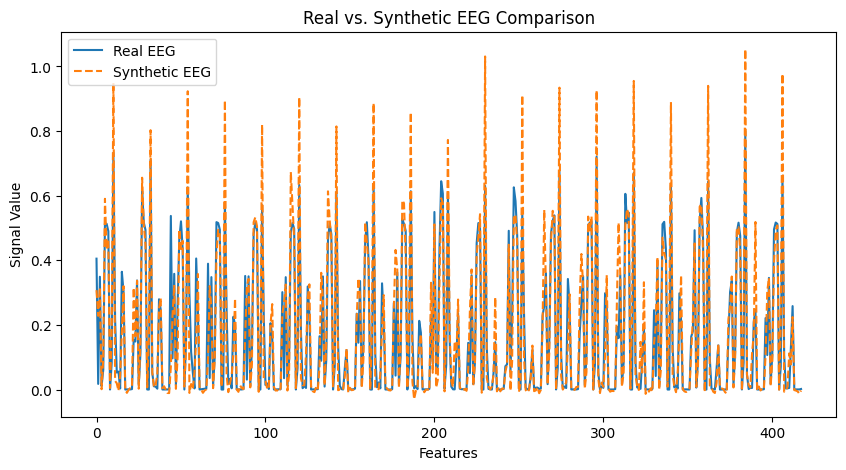

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

real_data = pd.read_csv("Normalized_Features.csv")
synthetic_data = pd.read_csv("Syn_data.csv")

real_sample = real_data.iloc[0, 1:-1].values  
synthetic_sample = synthetic_data.iloc[0, 1:-1].values  

# Plot EEG signals for comparison
plt.figure(figsize=(10, 5))
plt.plot(real_sample, label="Real EEG", linestyle="-")
plt.plot(synthetic_sample, label="Synthetic EEG", linestyle="--")
plt.xlabel("Features")
plt.ylabel("Signal Value")
plt.title("Real vs. Synthetic EEG Comparison")
plt.legend()
plt.show()


In [18]:
import pandas as pd


features_df = pd.read_csv("Normalized_Features.csv")
synthetic_df = pd.read_csv("Syn_data.csv")


combined_df = pd.concat([features_df, synthetic_df], ignore_index=True)

combined_df = combined_df.sample(frac=1).reset_index(drop=True)

combined_csv_output_filename = "Combined_data.csv"
combined_df.to_csv(combined_csv_output_filename, index=False)

print(f"Shuffled combined EEG data saved to {combined_csv_output_filename}")


Shuffled combined EEG data saved to Combined_data.csv


## DL with Syn Data

### CNN

#### 70 30

Dataset Shape: (6044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (4230, 418, 1)
Testing Data Shape: (1814, 418, 1)


d:\Miniconda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.5196 - loss: 1.0368 - val_accuracy: 0.6108 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6348 - loss: 0.8354 - val_accuracy: 0.6406 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6772 - loss: 0.7493 - val_accuracy: 0.6307 - val_loss: 0.8507 - learning_rate: 0.0010
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7013 - loss: 0.6904 - val_accuracy: 0.6499 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7245 - loss: 0.6270 - val_accuracy: 0.6119 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7387 - loss: 0.5904 - val_accuracy: 0.6538 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7608 - 

Model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6496 - loss: 0.7903
Test Accuracy: 64.99%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


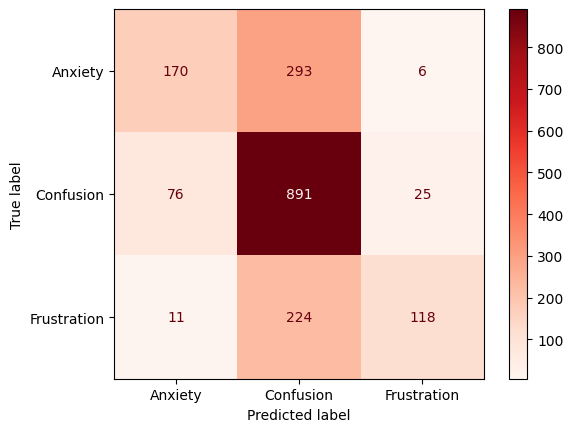


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.66      0.36      0.47       469
   Confusion       0.63      0.90      0.74       992
 Frustration       0.79      0.33      0.47       353

    accuracy                           0.65      1814
   macro avg       0.70      0.53      0.56      1814
weighted avg       0.67      0.65      0.62      1814



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1] 

X = data_numeric.values  
y = data.iloc[:, -1].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])


model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()


report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5536 - loss: 0.9899 - val_accuracy: 0.5566 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5776 - loss: 0.9511 - val_accuracy: 0.5698 - val_loss: 0.9525 - learning_rate: 0.0010
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5812 - loss: 0.9336 - val_accuracy: 0.5784 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5861 - loss: 0.9208 - val_accuracy: 0.5804 - val_loss: 0.9353 - learning_rate: 0.0010
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5938 - loss: 0.9037 - val_accuracy: 0.5890 - val_loss: 0.9319 - learning_rate: 0.0010
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 0.8898 - val_accuracy: 0.5890 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.8803 - val_a

Model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 0.9133
Test Accuracy: 61.81%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


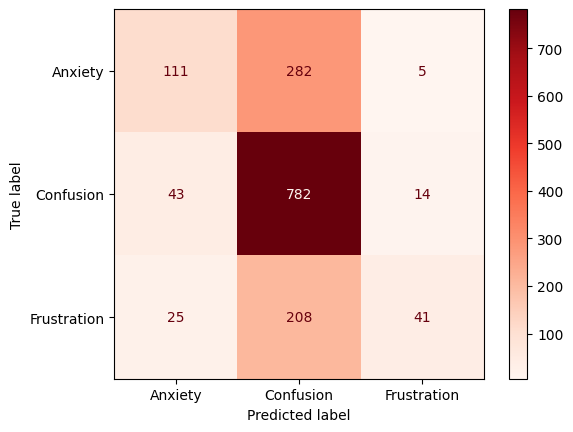


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.28      0.38       398
   Confusion       0.61      0.93      0.74       839
 Frustration       0.68      0.15      0.25       274

    accuracy                           0.62      1511
   macro avg       0.64      0.45      0.46      1511
weighted avg       0.63      0.62      0.56      1511



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1] 

X = data_numeric.values  
y = data.iloc[:, -1].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.25, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])


model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()


report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5572 - loss: 0.9918 - val_accuracy: 0.5451 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5754 - loss: 0.9439 - val_accuracy: 0.5666 - val_loss: 0.9550 - learning_rate: 0.0010
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5663 - loss: 0.9401 - val_accuracy: 0.5649 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5918 - loss: 0.9194 - val_accuracy: 0.5782 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6050 - loss: 0.9103 - val_accuracy: 0.5831 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5981 - loss: 0.9119 - val_accuracy: 0.5955 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6152 - loss: 0.8844 - val_a

Model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.9055 
Test Accuracy: 62.12%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


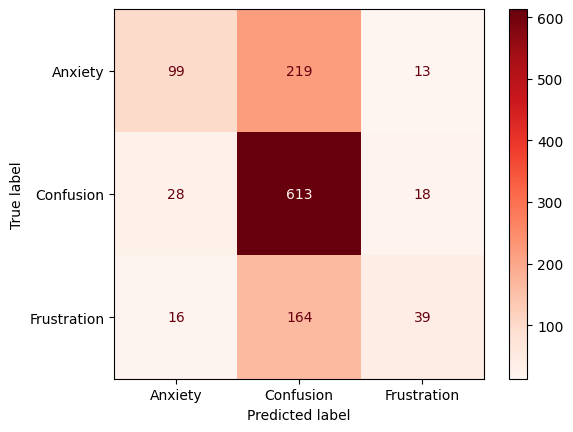


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.69      0.30      0.42       331
   Confusion       0.62      0.93      0.74       659
 Frustration       0.56      0.18      0.27       219

    accuracy                           0.62      1209
   macro avg       0.62      0.47      0.48      1209
weighted avg       0.63      0.62      0.57      1209



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1] 

X = data_numeric.values  
y = data.iloc[:, -1].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])


model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()


report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5451 - loss: 0.9918 - val_accuracy: 0.5669 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 0.9616 - val_accuracy: 0.5785 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5862 - loss: 0.9360 - val_accuracy: 0.5917 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 4/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5831 - loss: 0.9286 - val_accuracy: 0.5917 - val_loss: 0.9168 - learning_rate: 0.0010
Epoch 5/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5867 - loss: 0.9214 - val_accuracy: 0.5950 - val_loss: 0.9084 - learning_rate: 0.0010
Epoch 6/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 0.8817 - val_accuracy: 0.6198 - val_loss: 0.8965 - learning_rate: 0.0010
Epoch 7/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.8671 - val_a

Model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6098 - loss: 0.8869 
Test Accuracy: 62.81%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


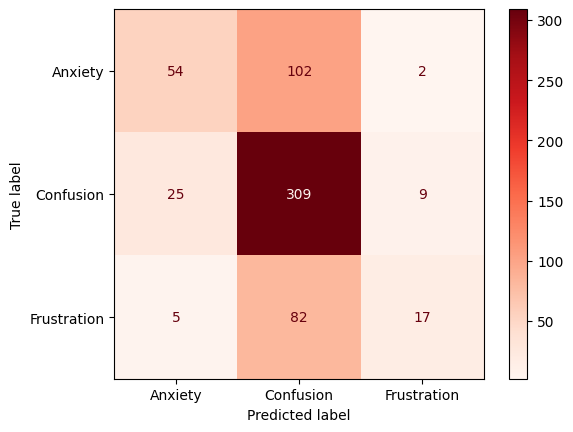


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.64      0.34      0.45       158
   Confusion       0.63      0.90      0.74       343
 Frustration       0.61      0.16      0.26       104

    accuracy                           0.63       605
   macro avg       0.63      0.47      0.48       605
weighted avg       0.63      0.63      0.58       605



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1] 

X = data_numeric.values  
y = data.iloc[:, -1].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.1, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])


model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()


report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


### LSTM

#### 70 30 

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4230, 22, 1)
Testing Data Shape: (1814, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5432 - loss: 1.0420 - val_accuracy: 0.5601 - val_loss: 0.9867 - learning_rate: 5.0000e-04
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5644 - loss: 0.9895 - val_accuracy: 0.5601 - val_loss: 0.9857 - learning_rate: 5.0000e-04
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5587 - loss: 0.9926 - val_accuracy: 0.5601 - val_loss: 0.9812 - learning_rate: 5.0000e-04
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5602 - loss: 0.9910 - val_accuracy: 0.5606 - val_loss: 0.9833 - learning_rate: 5.0000e-04
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5584 - loss: 0.9764 - val_accuracy: 0.5606 - val_loss: 0.9797 - learning_rate: 5.0000e-04
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5640 - loss: 0.9771 - val_accuracy: 0.5601 - val_loss: 0.9773 - learning_rate: 5.0000e-04
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy

LSTM model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5678 - loss: 0.9663
Test Accuracy: 56.84%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


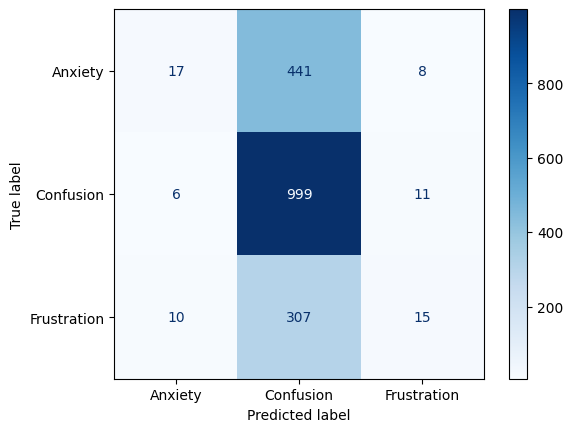


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.52      0.04      0.07       466
   Confusion       0.57      0.98      0.72      1016
 Frustration       0.44      0.05      0.08       332

    accuracy                           0.57      1814
   macro avg       0.51      0.35      0.29      1814
weighted avg       0.53      0.57      0.44      1814



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


file_path = 'Combined_data.csv' 
data = pd.read_csv(file_path)

# debugging
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values 
y = data.iloc[:, -1].values 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])


model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = np.argmax(model.predict(X_test), axis=1)


conf_matrix = confusion_matrix(y_test, y_pred)


ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()


report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)


print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5296 - loss: 1.0257 - val_accuracy: 0.5553 - val_loss: 1.0019 - learning_rate: 5.0000e-04
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5533 - loss: 0.9973 - val_accuracy: 0.5553 - val_loss: 0.9854 - learning_rate: 5.0000e-04
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5572 - loss: 0.9904 - val_accuracy: 0.5553 - val_loss: 0.9835 - learning_rate: 5.0000e-04
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5540 - loss: 0.9913 - val_accuracy: 0.5559 - val_loss: 0.9803 - learning_rate: 5.0000e-04
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5600 - loss: 0.9839 - val_accuracy: 0.5553 - val_loss: 0.9808 - learning_rate: 5.0000e-04
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5686 - loss: 0.9691 - val_accuracy: 0.5559 - val_loss: 0.9760 - learning_rate: 5.0000e-04
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy

LSTM model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5700 - loss: 0.9373
Test Accuracy: 57.38%
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


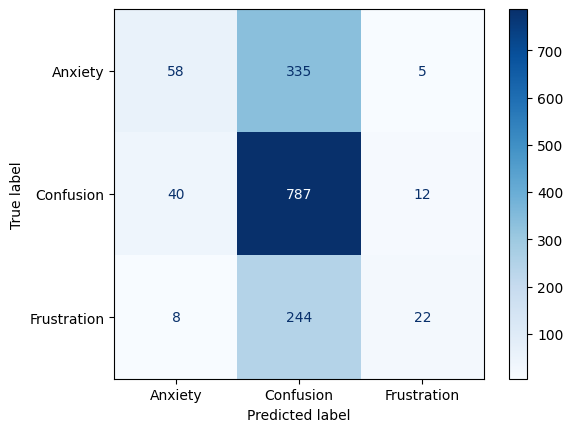


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.55      0.15      0.23       398
   Confusion       0.58      0.94      0.71       839
 Frustration       0.56      0.08      0.14       274

    accuracy                           0.57      1511
   macro avg       0.56      0.39      0.36      1511
weighted avg       0.57      0.57      0.48      1511



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


file_path = 'Combined_data.csv' 
data = pd.read_csv(file_path)

# debugging
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values 
y = data.iloc[:, -1].values 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])


model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = np.argmax(model.predict(X_test), axis=1)


conf_matrix = confusion_matrix(y_test, y_pred)


ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()


report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)


print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5551 - loss: 1.0194 - val_accuracy: 0.5451 - val_loss: 0.9943 - learning_rate: 5.0000e-04
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5536 - loss: 0.9985 - val_accuracy: 0.5451 - val_loss: 0.9938 - learning_rate: 5.0000e-04
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5511 - loss: 0.9995 - val_accuracy: 0.5451 - val_loss: 0.9961 - learning_rate: 5.0000e-04
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5688 - loss: 0.9809 - val_accuracy: 0.5451 - val_loss: 0.9932 - learning_rate: 5.0000e-04
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5806 - loss: 0.9661 - val_accuracy: 0.5451 - val_loss: 0.9951 - learning_rate: 5.0000e-04
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5641 - loss: 0.9810 - val_accuracy: 0.5459 - val_loss: 0.9954 - learning_rate: 5.0000e-04
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy

LSTM model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5665 - loss: 0.9399
Test Accuracy: 57.15%
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


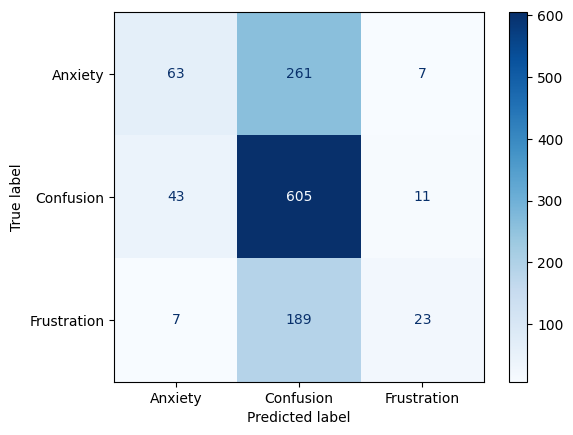


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.56      0.19      0.28       331
   Confusion       0.57      0.92      0.71       659
 Frustration       0.56      0.11      0.18       219

    accuracy                           0.57      1209
   macro avg       0.56      0.40      0.39      1209
weighted avg       0.57      0.57      0.49      1209



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


file_path = 'Combined_data.csv' 
data = pd.read_csv(file_path)

# debugging
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values 
y = data.iloc[:, -1].values 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])


model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = np.argmax(model.predict(X_test), axis=1)


conf_matrix = confusion_matrix(y_test, y_pred)


ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()


report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)


print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5570 - loss: 1.0230 - val_accuracy: 0.5669 - val_loss: 0.9748 - learning_rate: 5.0000e-04
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5678 - loss: 0.9825 - val_accuracy: 0.5669 - val_loss: 0.9768 - learning_rate: 5.0000e-04
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5620 - loss: 0.9887 - val_accuracy: 0.5669 - val_loss: 0.9775 - learning_rate: 5.0000e-04
Epoch 4/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5689 - loss: 0.9794 - val_accuracy: 0.5669 - val_loss: 0.9678 - learning_rate: 5.0000e-04
Epoch 5/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5581 - loss: 0.9821 - val_accuracy: 0.5669 - val_loss: 0.9669 - learning_rate: 5.0000e-04
Epoch 6/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5674 - loss: 0.9742 - val_accuracy: 0.5669 - val_loss: 0.9656 - learning_rate: 5.0000e-04
Epoch 7/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy

LSTM model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5857 - loss: 0.9187
Test Accuracy: 59.34%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


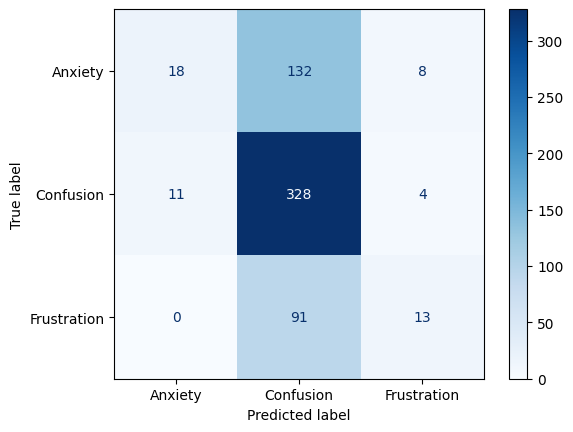


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.11      0.19       158
   Confusion       0.60      0.96      0.73       343
 Frustration       0.52      0.12      0.20       104

    accuracy                           0.59       605
   macro avg       0.58      0.40      0.38       605
weighted avg       0.59      0.59      0.50       605



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


file_path = 'Combined_data.csv' 
data = pd.read_csv(file_path)

# debugging
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values 
y = data.iloc[:, -1].values 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])


model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


y_pred = np.argmax(model.predict(X_test), axis=1)


conf_matrix = confusion_matrix(y_test, y_pred)


ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()


report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)


print("\nClassification Report:")
print(report)


### Conformer

#### 70 30

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4230, 22, 1)
Testing Data Shape: (1814, 22, 1)
Epoch 1/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5364 - loss: 1.0925 - val_accuracy: 0.5662 - val_loss: 0.9956 - learning_rate: 0.0010
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5528 - loss: 0.9881 - val_accuracy: 0.5606 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.

Model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.8864
Test Accuracy: 60.09%
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


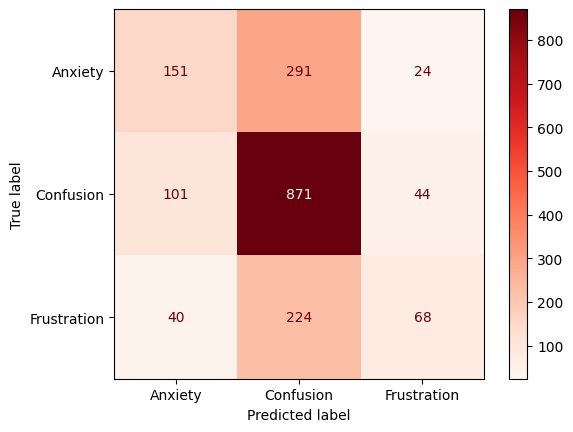


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.52      0.32      0.40       466
   Confusion       0.63      0.86      0.73      1016
 Frustration       0.50      0.20      0.29       332

    accuracy                           0.60      1814
   macro avg       0.55      0.46      0.47      1814
weighted avg       0.58      0.60      0.56      1814



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5140 - loss: 1.0947 - val_accuracy: 0.5433 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5456 - loss: 0.9922 - val_accuracy: 0.5566 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.

Model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.8873
Test Accuracy: 60.75%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


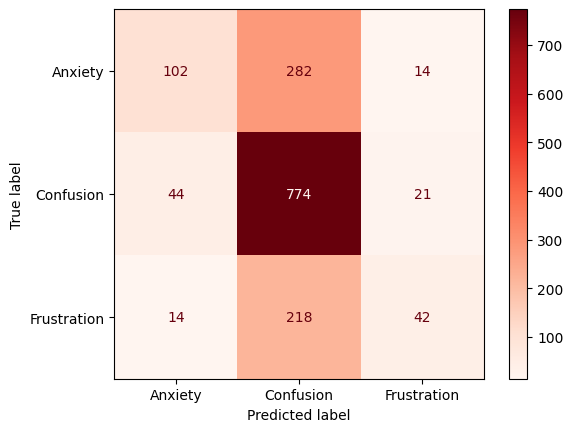


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.64      0.26      0.37       398
   Confusion       0.61      0.92      0.73       839
 Frustration       0.55      0.15      0.24       274

    accuracy                           0.61      1511
   macro avg       0.60      0.44      0.45      1511
weighted avg       0.60      0.61      0.55      1511



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5436 - loss: 1.0719 - val_accuracy: 0.5451 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5700 - loss: 0.9677 - val_accuracy: 0.5567 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5

Model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6082 - loss: 0.8901
Test Accuracy: 61.04%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


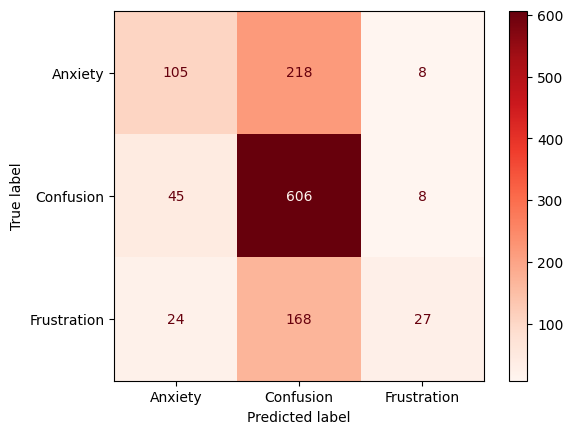


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.60      0.32      0.42       331
   Confusion       0.61      0.92      0.73       659
 Frustration       0.63      0.12      0.21       219

    accuracy                           0.61      1209
   macro avg       0.61      0.45      0.45      1209
weighted avg       0.61      0.61      0.55      1209



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5363 - loss: 1.0705 - val_accuracy: 0.5669 - val_loss: 0.9681 - learning_rate: 0.0010
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5563 - loss: 0.9780 - val_accuracy: 0.5736 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.563

Model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6106 - loss: 0.9008 
Test Accuracy: 63.97%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


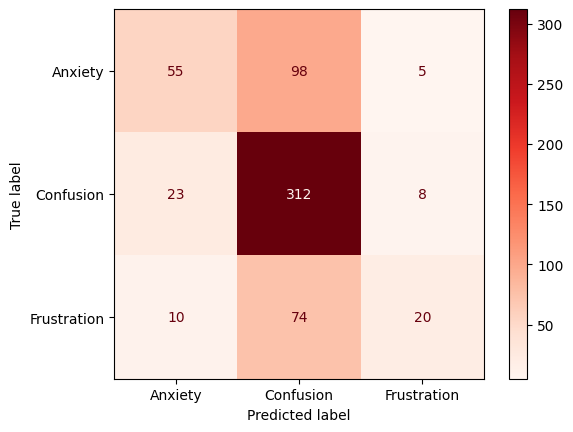


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.35      0.45       158
   Confusion       0.64      0.91      0.75       343
 Frustration       0.61      0.19      0.29       104

    accuracy                           0.64       605
   macro avg       0.63      0.48      0.50       605
weighted avg       0.63      0.64      0.59       605



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Combined_data.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


## DL without Syn data

### CNN

#### 70 30

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5666 - loss: 0.9902 - val_accuracy: 0.6619 - val_loss: 0.7670 - learning_rate: 0.0010
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7079 - loss: 0.6769 - val_accuracy: 0.7243 - val_loss: 0.6603 - learning_rate: 0.0010
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7742 - loss: 0.5377 - val_accuracy: 0.7560 - val_loss: 0.6034 - learning_rate: 0.0010
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8125 - loss: 0.4531 - val_accuracy: 0.7604 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8783 - loss: 0.3274 - val_accuracy: 0.7527 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9040 - loss: 0.2632 - val_accuracy: 0.7976 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9345 - loss: 0.2090 - val_accuracy

Model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7897 - loss: 0.4951
Test Accuracy: 79.76%
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


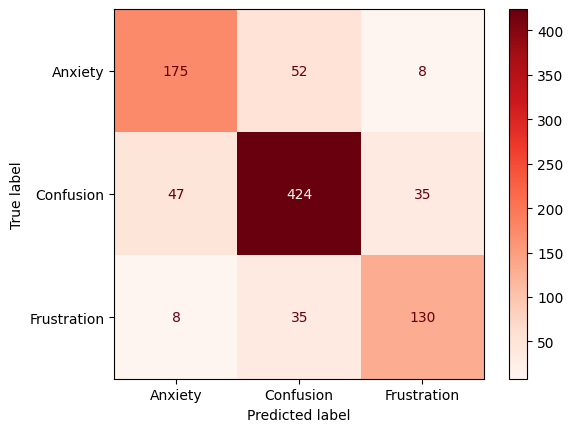


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.76      0.74      0.75       235
   Confusion       0.83      0.84      0.83       506
 Frustration       0.75      0.75      0.75       173

    accuracy                           0.80       914
   macro avg       0.78      0.78      0.78       914
weighted avg       0.80      0.80      0.80       914



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2283, 418, 1)
Testing Data Shape: (761, 418, 1)
Epoch 1/200


d:\Miniconda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5887 - loss: 0.9260 - val_accuracy: 0.6991 - val_loss: 0.7472 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7527 - loss: 0.5570 - val_accuracy: 0.7766 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8318 - loss: 0.4095 - val_accuracy: 0.7819 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8779 - loss: 0.3215 - val_accuracy: 0.7556 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8879 - loss: 0.3013 - val_accuracy: 0.8095 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9185 - loss: 0.2279 - val_accuracy: 0.7937 - val_loss: 0.5550 - learning_rate: 0.0010
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9457 - loss: 0.1672 - val_accuracy

Model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7741 - loss: 0.5328
Test Accuracy: 77.66%
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


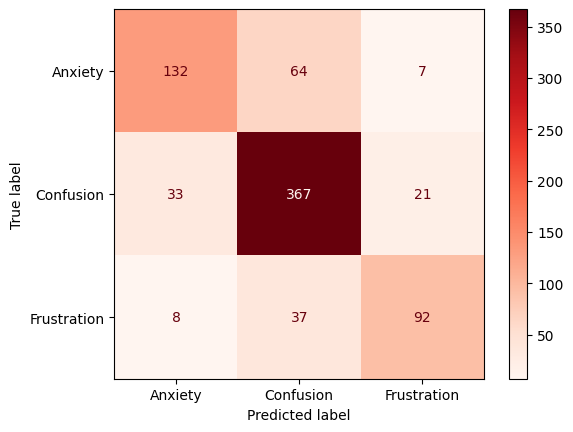


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.76      0.65      0.70       203
   Confusion       0.78      0.87      0.83       421
 Frustration       0.77      0.67      0.72       137

    accuracy                           0.78       761
   macro avg       0.77      0.73      0.75       761
weighted avg       0.78      0.78      0.77       761



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.25, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2435, 418, 1)
Testing Data Shape: (609, 418, 1)
Epoch 1/200


d:\Miniconda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5935 - loss: 0.9439 - val_accuracy: 0.6732 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7030 - loss: 0.6667 - val_accuracy: 0.7011 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7852 - loss: 0.5084 - val_accuracy: 0.7816 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8362 - loss: 0.4018 - val_accuracy: 0.7652 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8711 - loss: 0.3257 - val_accuracy: 0.7225 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8856 - loss: 0.2959 - val_accuracy: 0.7816 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8931 - loss: 0.2617 - val_accuracy

Model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8002 - loss: 0.4758
Test Accuracy: 79.97%
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


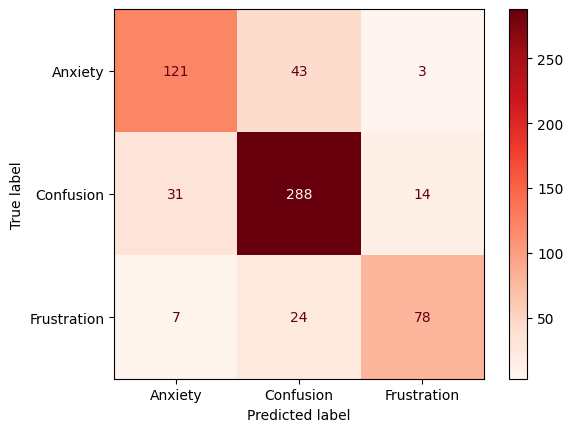


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.76      0.72      0.74       167
   Confusion       0.81      0.86      0.84       333
 Frustration       0.82      0.72      0.76       109

    accuracy                           0.80       609
   macro avg       0.80      0.77      0.78       609
weighted avg       0.80      0.80      0.80       609



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2739, 418, 1)
Testing Data Shape: (305, 418, 1)
Epoch 1/200


d:\Miniconda\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5956 - loss: 0.9267 - val_accuracy: 0.6984 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7425 - loss: 0.6073 - val_accuracy: 0.7836 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7975 - loss: 0.4822 - val_accuracy: 0.8033 - val_loss: 0.4666 - learning_rate: 0.0010
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8397 - loss: 0.3768 - val_accuracy: 0.8098 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8641 - loss: 0.3433 - val_accuracy: 0.8098 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8737 - loss: 0.3074 - val_accuracy: 0.8033 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9176 - loss: 0.2108 - val_accuracy

Model saved successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7788 - loss: 0.5192
Test Accuracy: 80.98%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


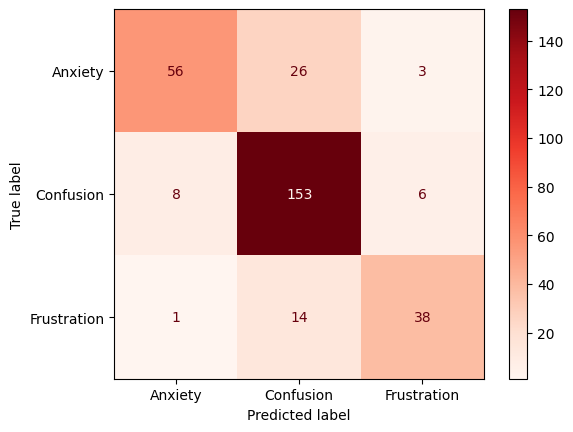


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.86      0.66      0.75        85
   Confusion       0.79      0.92      0.85       167
 Frustration       0.81      0.72      0.76        53

    accuracy                           0.81       305
   macro avg       0.82      0.76      0.79       305
weighted avg       0.81      0.81      0.81       305



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.1, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('CNN_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


### LSTM

#### 70 30 

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)


d:\Miniconda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5015 - loss: 1.0523 - val_accuracy: 0.5536 - val_loss: 0.9846 - learning_rate: 5.0000e-04
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5549 - loss: 0.9899 - val_accuracy: 0.5536 - val_loss: 0.9790 - learning_rate: 5.0000e-04
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5694 - loss: 0.9668 - val_accuracy: 0.5536 - val_loss: 0.9480 - learning_rate: 5.0000e-04
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5657 - loss: 0.9535 - val_accuracy: 0.5449 - val_loss: 1.0068 - learning_rate: 5.0000e-04
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5436 - loss: 0.9882 - val_accuracy: 0.5536 - val_loss: 0.9639 - learning_rate: 5.0000e-04
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5604 - loss: 0.9764 - val_accuracy: 0.5646 - val_loss: 0.9447 - learning_rate: 5.0000e-04
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5

LSTM model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.6186 - loss: 0.8563
Test Accuracy: 62.58%
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step


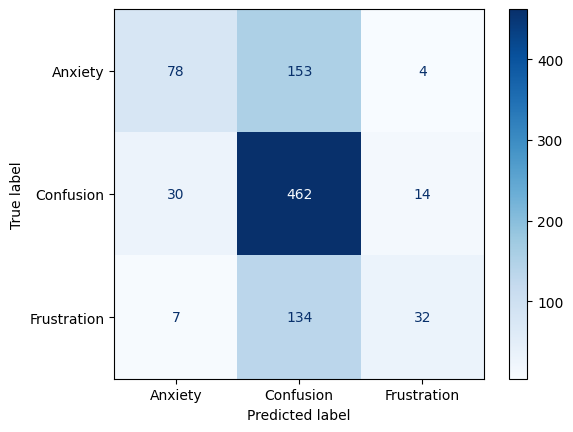


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.68      0.33      0.45       235
   Confusion       0.62      0.91      0.74       506
 Frustration       0.64      0.18      0.29       173

    accuracy                           0.63       914
   macro avg       0.65      0.48      0.49       914
weighted avg       0.64      0.63      0.58       914



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (2283, 22, 1)
Testing Data Shape: (761, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5240 - loss: 1.0440 - val_accuracy: 0.5532 - val_loss: 0.9845 - learning_rate: 5.0000e-04
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5675 - loss: 0.9664 - val_accuracy: 0.5532 - val_loss: 0.9732 - learning_rate: 5.0000e-04
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5911 - loss: 0.9374 - val_accuracy: 0.5585 - val_loss: 0.9657 - learning_rate: 5.0000e-04
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5653 - loss: 0.9693 - val_accuracy: 0.5585 - val_loss: 0.9605 - learning_rate: 5.0000e-04
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5743 - loss: 0.9417 - val_accuracy: 0.5572 - val_loss: 0.9590 - learning_rate: 5.0000e-04
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5546 - loss: 0.9502 - val_accuracy: 0.5585 - val_loss: 0.9494 - learning_rate: 5.0000e-04
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5736 - los

LSTM model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5911 - loss: 0.8905
Test Accuracy: 60.05%
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


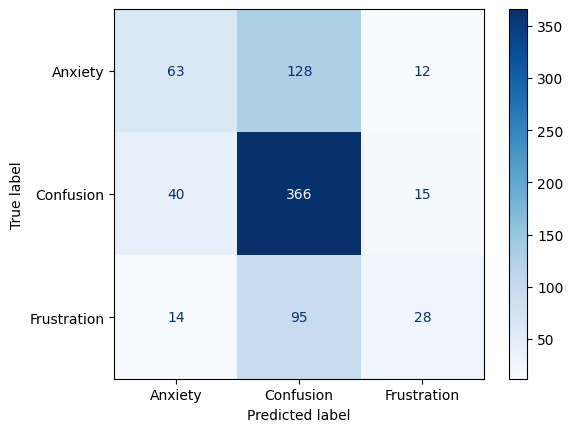


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.54      0.31      0.39       203
   Confusion       0.62      0.87      0.72       421
 Frustration       0.51      0.20      0.29       137

    accuracy                           0.60       761
   macro avg       0.56      0.46      0.47       761
weighted avg       0.58      0.60      0.56       761



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (2435, 22, 1)
Testing Data Shape: (609, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5489 - loss: 1.0408 - val_accuracy: 0.5468 - val_loss: 0.9889 - learning_rate: 5.0000e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5594 - loss: 0.9806 - val_accuracy: 0.5484 - val_loss: 0.9694 - learning_rate: 5.0000e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5565 - loss: 0.9787 - val_accuracy: 0.5501 - val_loss: 0.9715 - learning_rate: 5.0000e-04
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5749 - loss: 0.9553 - val_accuracy: 0.5534 - val_loss: 0.9649 - learning_rate: 5.0000e-04
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5745 - loss: 0.9575 - val_accuracy: 0.5534 - val_loss: 0.9537 - learning_rate: 5.0000e-04
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5651 - loss: 0.9558 - val_accuracy: 0.5583 - val_loss: 0.9490 - learning_rate: 5.0000e-04
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5541 - los

LSTM model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6110 - loss: 0.8687
Test Accuracy: 61.08%
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


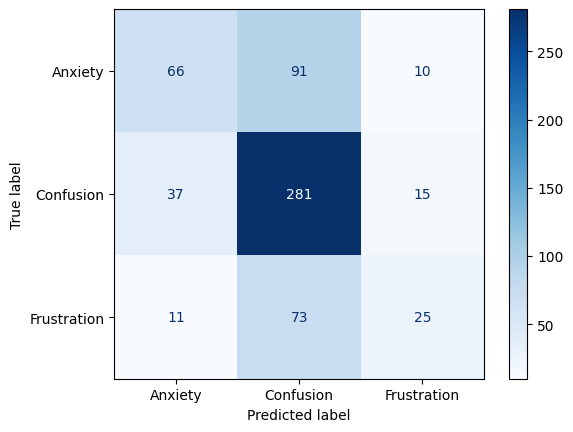


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.58      0.40      0.47       167
   Confusion       0.63      0.84      0.72       333
 Frustration       0.50      0.23      0.31       109

    accuracy                           0.61       609
   macro avg       0.57      0.49      0.50       609
weighted avg       0.59      0.61      0.58       609



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (3044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (2739, 22, 1)
Testing Data Shape: (305, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5644 - loss: 1.0323 - val_accuracy: 0.5475 - val_loss: 0.9837 - learning_rate: 5.0000e-04
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5635 - loss: 0.9803 - val_accuracy: 0.5475 - val_loss: 0.9770 - learning_rate: 5.0000e-04
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5578 - loss: 0.9754 - val_accuracy: 0.5475 - val_loss: 0.9649 - learning_rate: 5.0000e-04
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5616 - loss: 0.9605 - val_accuracy: 0.5508 - val_loss: 0.9687 - learning_rate: 5.0000e-04
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5740 - loss: 0.9544 - val_accuracy: 0.5508 - val_loss: 0.9549 - learning_rate: 5.0000e-04
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5579 - loss: 0.9587 - val_accuracy: 0.5443 - val_loss: 0.9436 - learning_rate: 5.0000e-04
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5479 - los

LSTM model saved successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5814 - loss: 0.8534
Test Accuracy: 60.00%
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


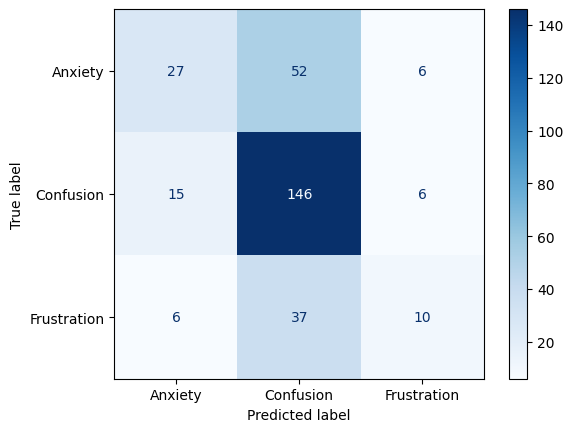


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.56      0.32      0.41        85
   Confusion       0.62      0.87      0.73       167
 Frustration       0.45      0.19      0.27        53

    accuracy                           0.60       305
   macro avg       0.55      0.46      0.47       305
weighted avg       0.58      0.60      0.56       305



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


### Conformer

#### 70 30

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)
Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.4483 - loss: 2.6974 - val_accuracy: 0.6313 - val_loss: 0.9134 - learning_rate: 0.0010
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5881 - loss: 0.9271 - val_accuracy: 0.6838 - val_loss: 0.8133 - learning_rate: 0.0010
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.6241 - loss: 0.8232 - val_accuracy: 0.64

Model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7881 - loss: 0.5724
Test Accuracy: 79.21%
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


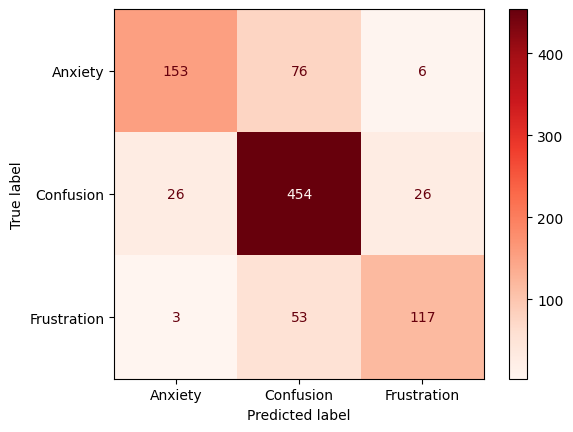


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.84      0.65      0.73       235
   Confusion       0.78      0.90      0.83       506
 Frustration       0.79      0.68      0.73       173

    accuracy                           0.79       914
   macro avg       0.80      0.74      0.76       914
weighted avg       0.80      0.79      0.79       914



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2283, 418, 1)
Testing Data Shape: (761, 418, 1)
Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.4467 - loss: 2.2028 - val_accuracy: 0.4901 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5897 - loss: 0.8908 - val_accuracy: 0.6439 - val_loss: 0.7695 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.7089 - loss: 0.6902 - val_accuracy: 0.7

Model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8065 - loss: 0.5163
Test Accuracy: 81.08%
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


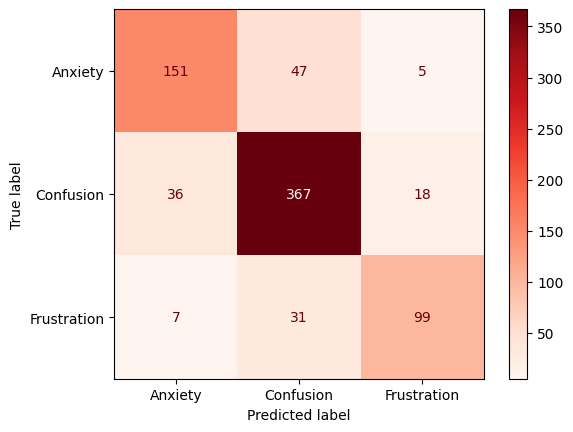


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.78      0.74      0.76       203
   Confusion       0.82      0.87      0.85       421
 Frustration       0.81      0.72      0.76       137

    accuracy                           0.81       761
   macro avg       0.80      0.78      0.79       761
weighted avg       0.81      0.81      0.81       761



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2435, 418, 1)
Testing Data Shape: (609, 418, 1)
Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.4959 - loss: 1.8070 - val_accuracy: 0.6322 - val_loss: 0.8316 - learning_rate: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.6402 - loss: 0.8306 - val_accuracy: 0.6929 - val_loss: 0.7118 - learning_rate: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7686 - loss: 0.6114 - val_accuracy: 0.7

Model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7700 - loss: 0.5296
Test Accuracy: 78.33%
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


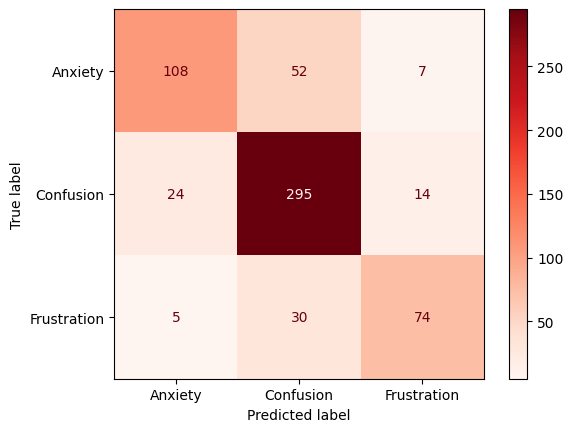


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.79      0.65      0.71       167
   Confusion       0.78      0.89      0.83       333
 Frustration       0.78      0.68      0.73       109

    accuracy                           0.78       609
   macro avg       0.78      0.74      0.76       609
weighted avg       0.78      0.78      0.78       609



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2739, 418, 1)
Testing Data Shape: (305, 418, 1)
Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.4653 - loss: 2.5908 - val_accuracy: 0.5475 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.5676 - loss: 1.0709 - val_accuracy: 0.5475 - val_loss: 1.0559 - learning_rate: 0.0010
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.5844 - loss: 1.0436 - val_accuracy: 0.5

Model saved successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5578 - loss: 0.9854
Test Accuracy: 54.75%
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


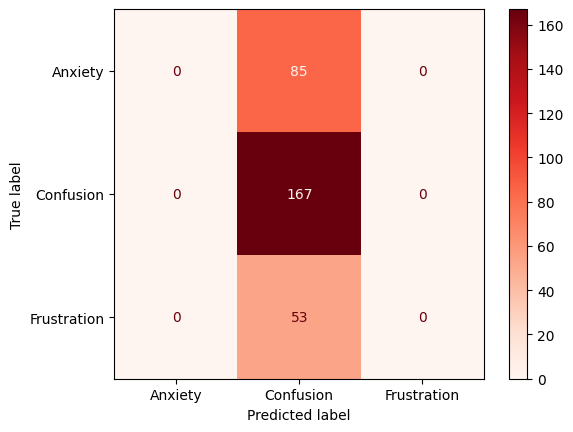


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.00      0.00      0.00        85
   Confusion       0.55      1.00      0.71       167
 Frustration       0.00      0.00      0.00        53

    accuracy                           0.55       305
   macro avg       0.18      0.33      0.24       305
weighted avg       0.30      0.55      0.39       305



d:\Miniconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


## ML

### SVM

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.79      0.42      0.55       235
   Confusion       0.68      0.93      0.78       506
 Frustration       0.79      0.43      0.55       173

    accuracy                           0.70       914
   macro avg       0.75      0.59      0.63       914
weighted avg       0.73      0.70      0.68       914



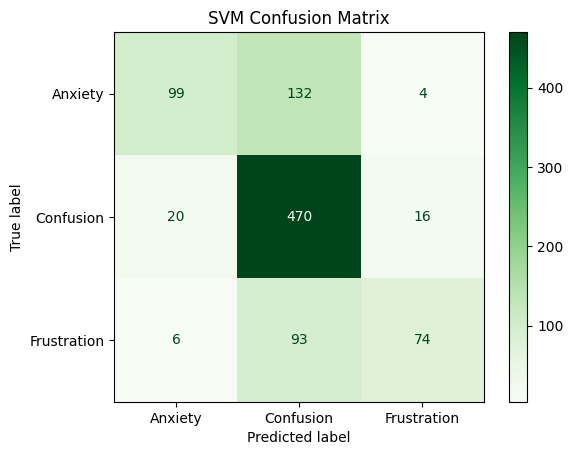

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.savefig("confusion_matrix_SVM.png")
plt.show()


### RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.83      0.51      0.63       235
   Confusion       0.69      0.96      0.80       506
 Frustration       0.87      0.34      0.49       173

    accuracy                           0.73       914
   macro avg       0.80      0.60      0.64       914
weighted avg       0.76      0.73      0.70       914



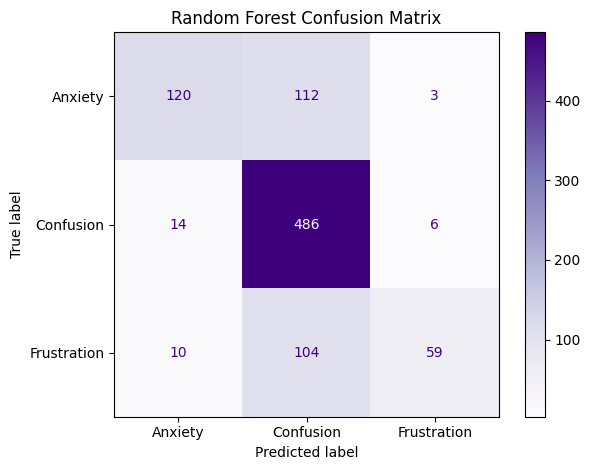

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Purples')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_RF.png")
plt.show()


### XG BOOST

In [23]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


d:\Miniconda\envs\tf\lib\site-packages\xgboost\training.py:183: UserWarning: [14:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.78      0.59      0.67       235
   Confusion       0.73      0.93      0.82       506
 Frustration       0.82      0.46      0.59       173

    accuracy                           0.75       914
   macro avg       0.78      0.66      0.69       914
weighted avg       0.76      0.75      0.74       914



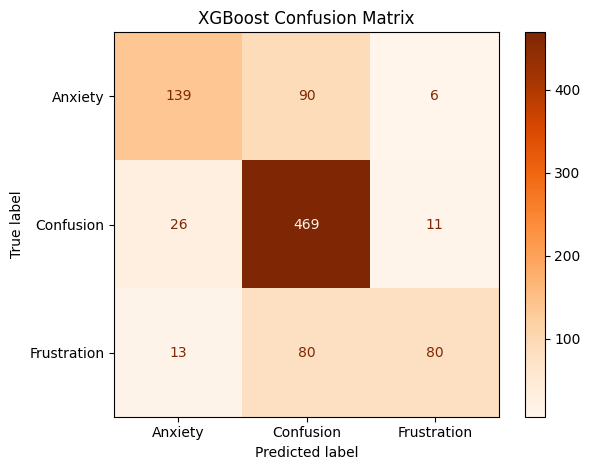

Training complete and data saved for ROC & PR curve plotting.


In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import h5py
import joblib

# Load dataset
data = pd.read_csv('Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_XGBoost.png")
plt.show()


model_raw = xgb_model.get_booster().save_raw()
with h5py.File('xgb_model.h5', 'w') as h5f:
    h5f.create_dataset('xgb_model_raw', data=np.void(model_raw))


# One-hot encode y_test for ROC/PR curves
onehot_encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1))

# Save relevant data
np.save('y_test_onehot.npy', y_test_onehot)
np.save('y_proba.npy', y_proba)
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Training complete and data saved for ROC & PR curve plotting.")


In [5]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


### KNN

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.60      0.52      0.56       235
   Confusion       0.69      0.86      0.77       506
 Frustration       0.85      0.39      0.53       173

    accuracy                           0.68       914
   macro avg       0.71      0.59      0.62       914
weighted avg       0.70      0.68      0.67       914



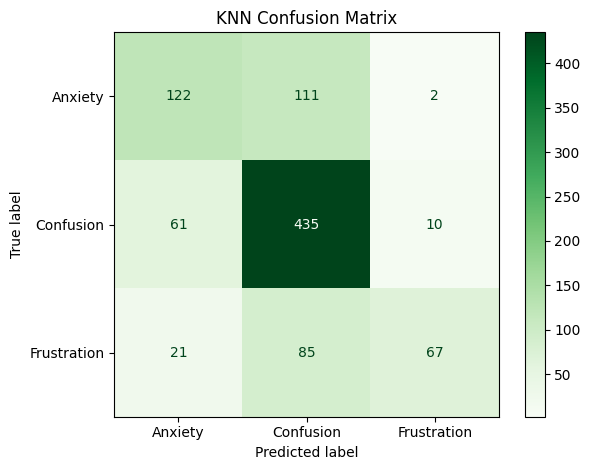

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_KNN.png")
plt.show()


## Graphs

### Boxplot / Violin plot

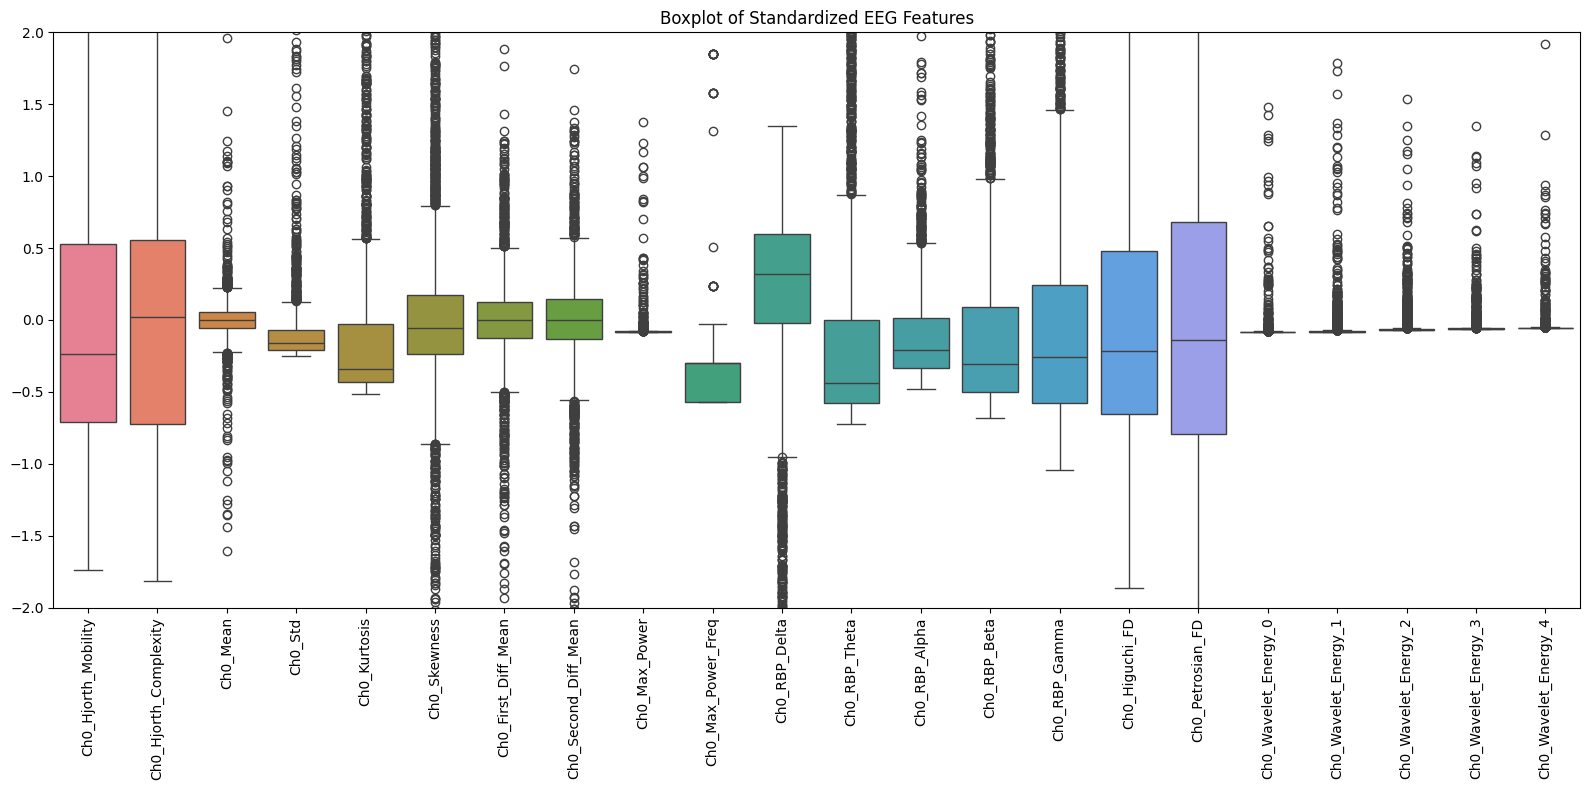

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('ExtractedFeatures.csv')
numeric_features = df.select_dtypes(include=['number'])

scaler = StandardScaler()
scaled_array = scaler.fit_transform(numeric_features)

scaled_df = pd.DataFrame(scaled_array, columns=numeric_features.columns)

plt.figure(figsize=(16, 8))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.ylim(-2, 2)
plt.title("Boxplot of Standardized EEG Features")
plt.tight_layout()
plt.show()


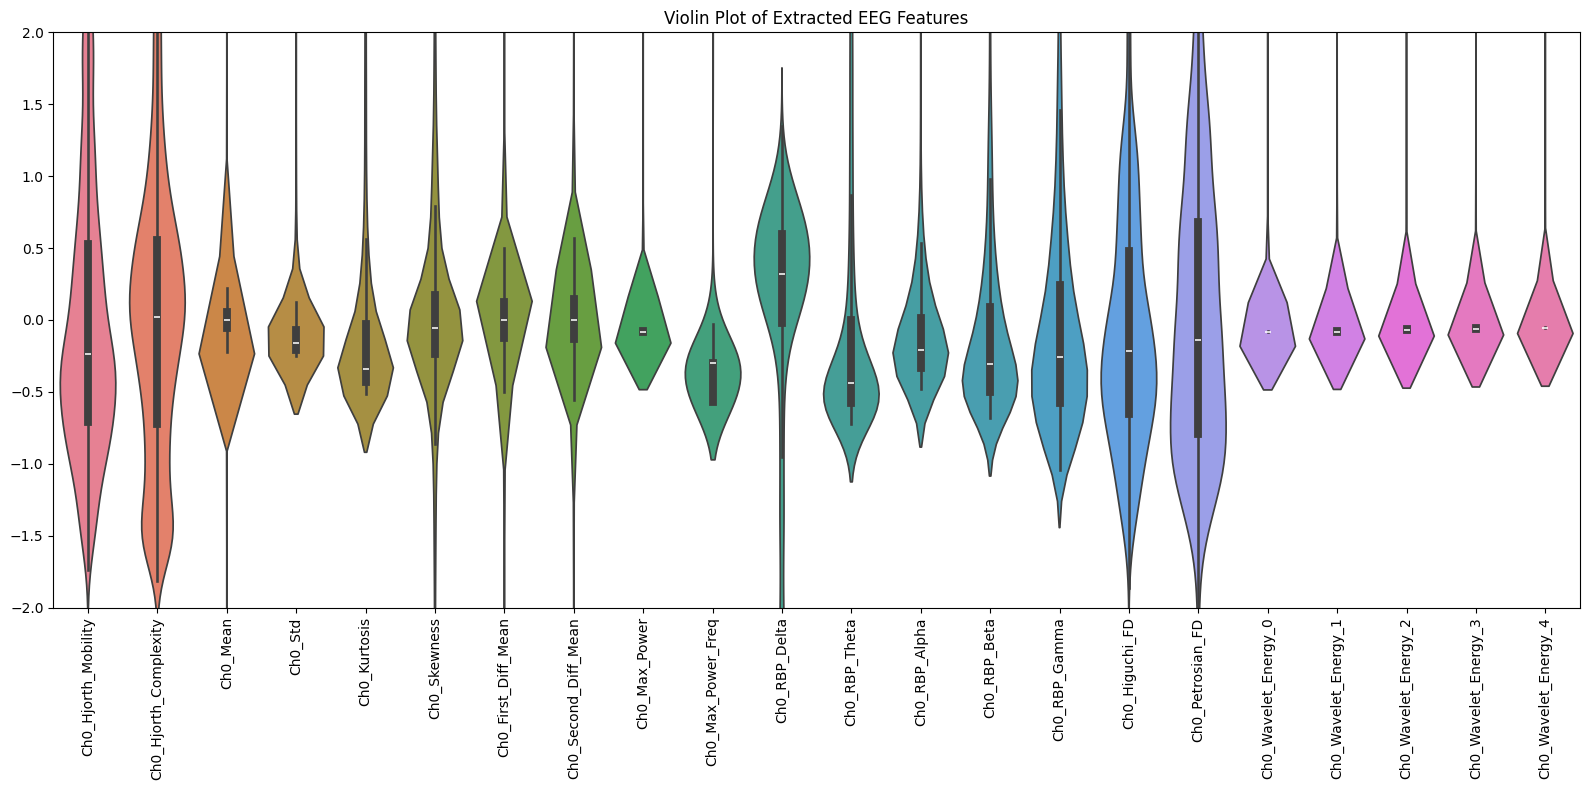

In [ ]:
plt.figure(figsize=(16, 8))
sns.violinplot(data=scaled_df)
plt.xticks(rotation=90)
plt.ylim(-2, 2)  
plt.title("Violin Plot of Extracted EEG Features")
plt.tight_layout()
plt.show()


### Correlation Matrix(HeatMap)

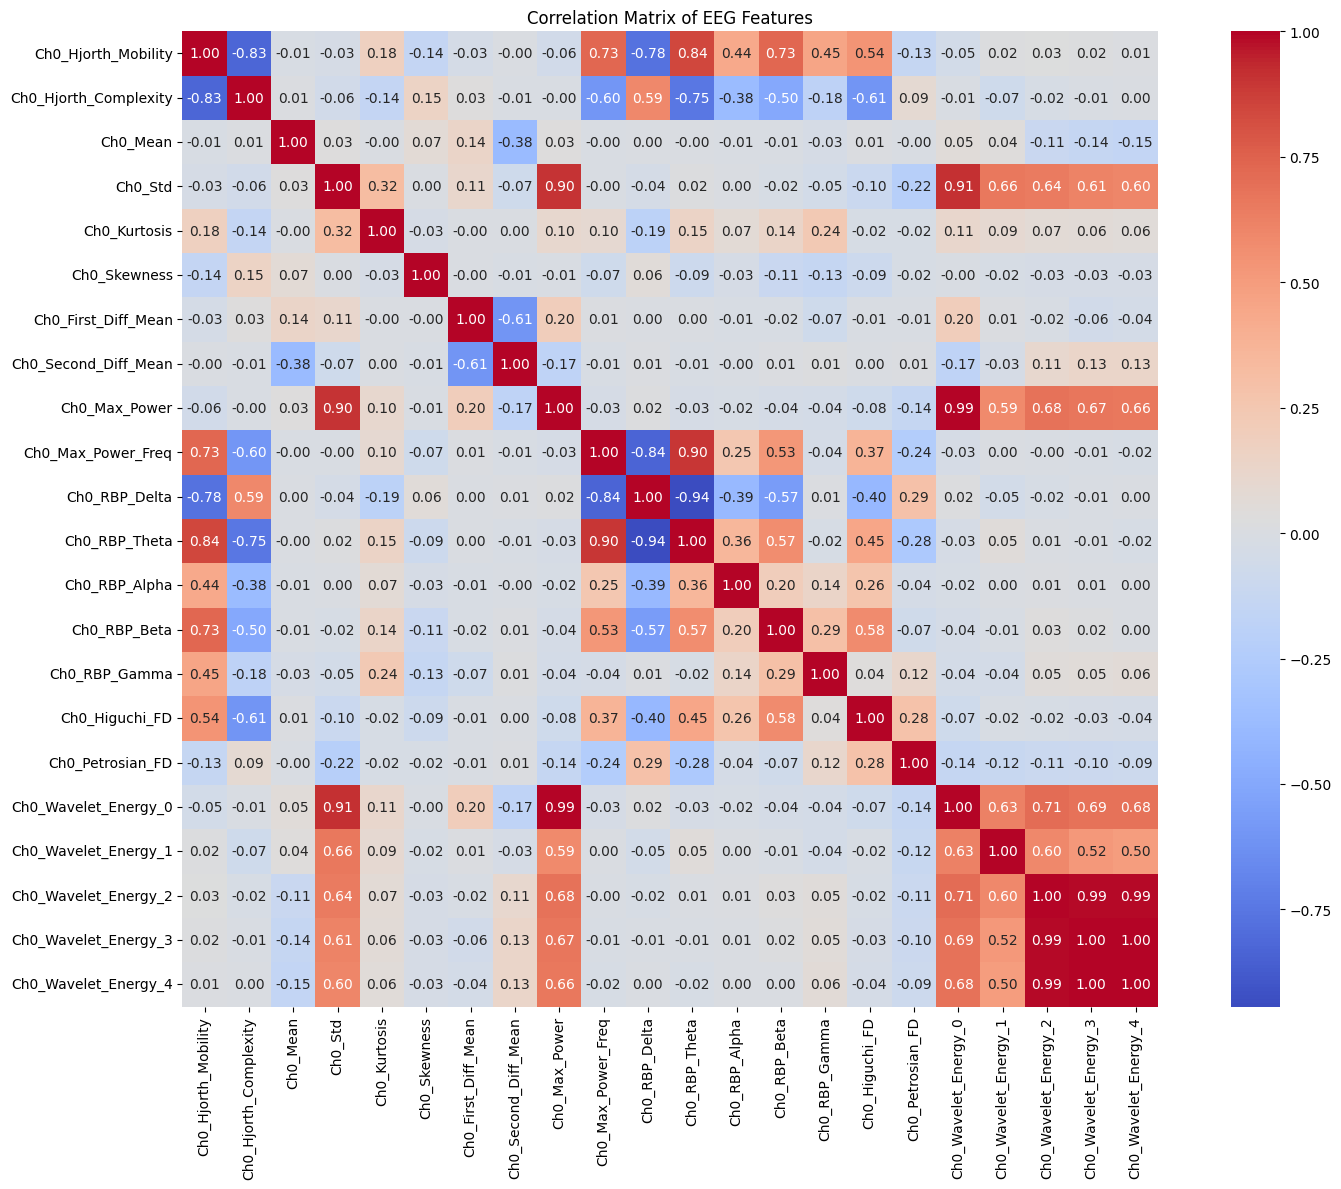

In [ ]:
correlation_matrix = numeric_features.corr() 

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of EEG Features")
plt.tight_layout()
plt.show()


### Real vs Synthetic feature Distribution

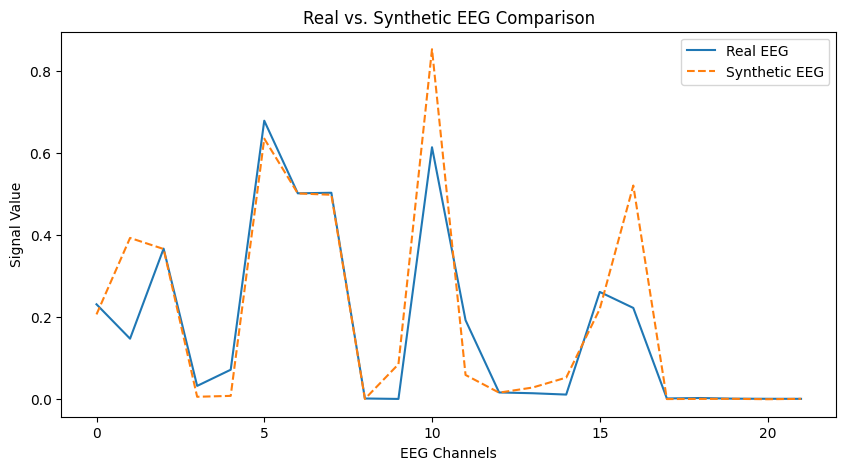

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

real_data = pd.read_csv("Normalized_Features.csv")
synthetic_data = pd.read_csv("Syn_data.csv")

real_sample = real_data.iloc[0, 1:-1].values  
synthetic_sample = synthetic_data.iloc[0, 1:-1].values  


plt.figure(figsize=(10, 5))
plt.plot(real_sample, label="Real EEG", linestyle="-")
plt.plot(synthetic_sample, label="Synthetic EEG", linestyle="--")
plt.xlabel("EEG Channels")
plt.ylabel("Signal Value")
plt.title("Real vs. Synthetic EEG Comparison")
plt.legend()
plt.show()


### Model Accuracy and Loss Curves

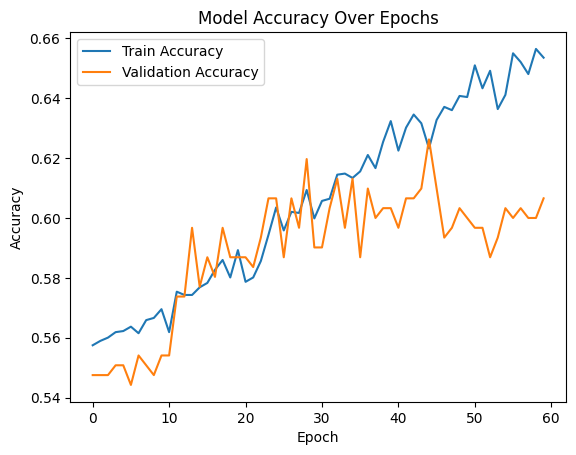

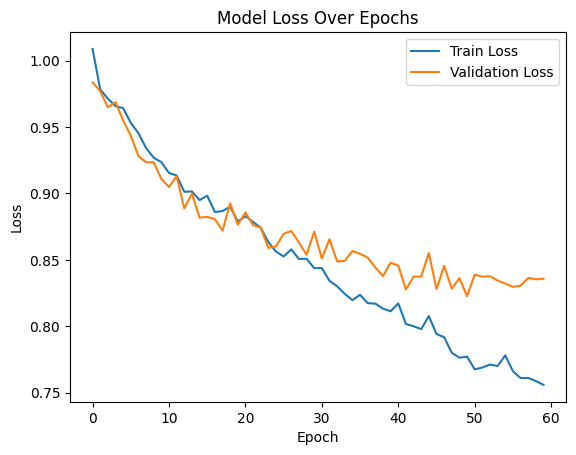

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### ROC Curves (for each class)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


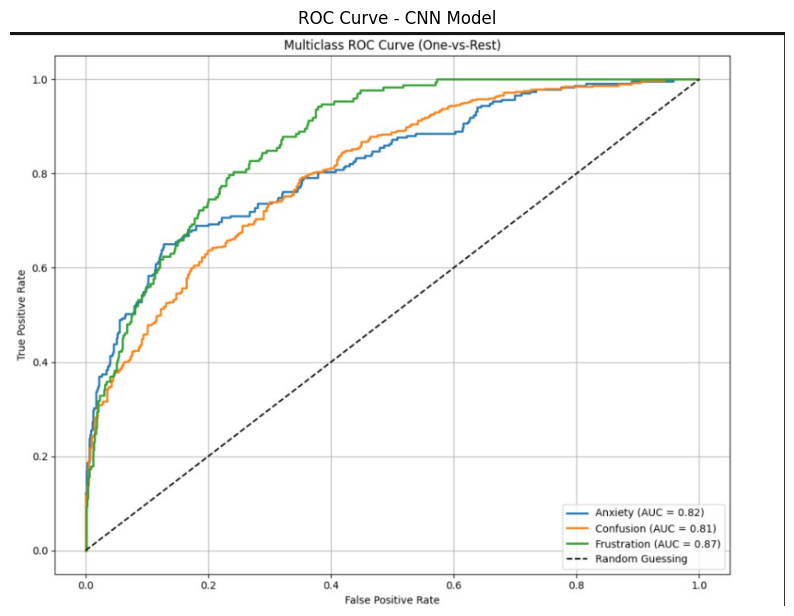

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


df = pd.read_csv('Normalized_Features.csv')

X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

model = load_model('CNN_EEG_model.h5')
y_score = model.predict(X_test)

img = mpimg.imread('cnn_roc.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off') 
plt.title('ROC Curve - CNN Model')
plt.show()


### Precision-Recall Curves

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


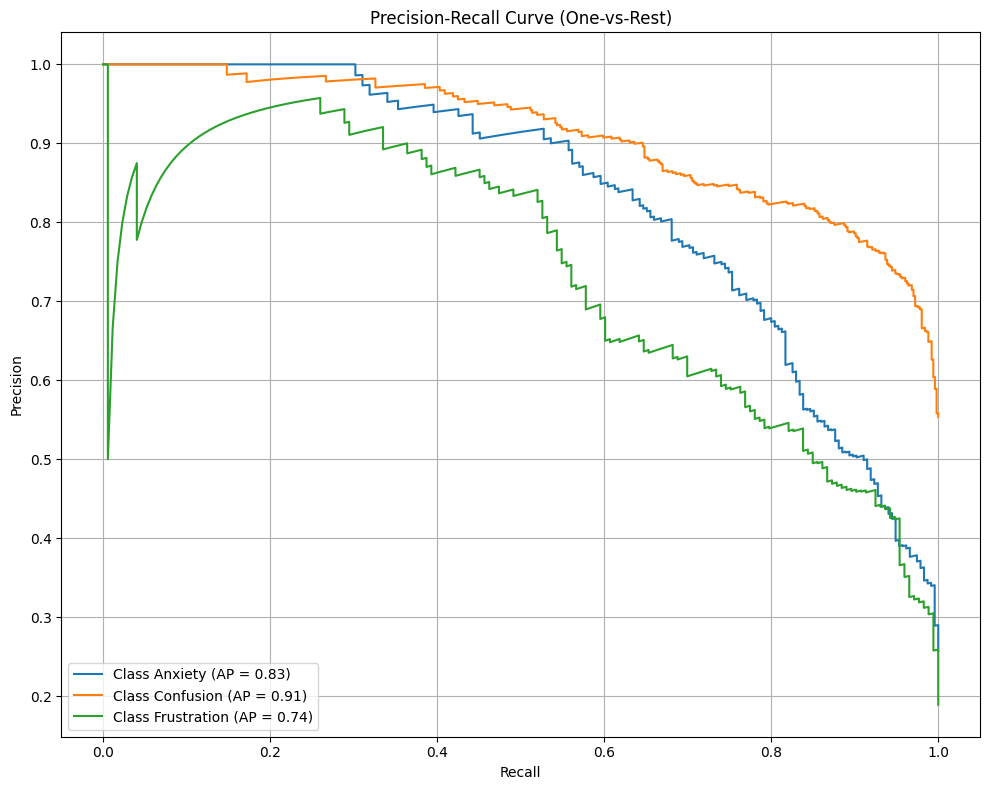

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score


df = pd.read_csv('Normalized_Features.csv')  


X = df.drop(columns=['Label'], errors='ignore')
y = df['Label']

X = X.select_dtypes(include=[np.number])

X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)


model = load_model('CNN_EEG_Model.h5') 
y_score = model.predict(X_test)

n_classes = y_score.shape[1]
y_test_bin = label_binarize(y_test, classes=range(n_classes))


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    class_name = le.inverse_transform([i])[0]  # Convert encoded label back to original
    plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


## CROSS VALIDATION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer  # Example dataset
from sklearn.preprocessing import StandardScaler

# Load and preprocess dataset
data = load_breast_cancer()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)  # Scale features

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Function to run cross-validation and plot results
def run_cross_validation(k, model, X, y):
    scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
    print(f"\n{k}-Fold Cross-Validation Accuracy Scores: {scores}")
    print(f"Average Accuracy: {np.mean(scores):.4f}")

    # Bar plot
    plt.figure(figsize=(8, 5))
    plt.bar([f'Fold {i+1}' for i in range(k)], scores, color='mediumseagreen')
    plt.ylim(0.90, 1.00)
    plt.title(f'{k}-Fold Cross-Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Perform 5-fold cross-validation
run_cross_validation(5, model, X, y)

# Perform 10-fold cross-validation
run_cross_validation(10, model, X, y)
